# NLP and Sentiment Analysis based Trading Strategy

Natural language processing offers the ability to quantify text. One can begin to ask questions such as- How positive or negative is this news? How can we quantify words? etc.


Algo trading automates the trading process in financial markets by rapidly and precisely executing orders based on a set of defined rules. They remove human error (provided the algorithms were developed without them) and they also remove the dangers of acting on emotion. The algorithms that are used in production can be fairly complex and heavily optimized with low-latency systems.

The focus of this case study are as follows:

* Producing news sentiments using different techniques such as supervised, unsupervised algorithms.
* Enhancing sentiment analysis by using a deep learning model such as LSTM. 
* Comparison of different sentiment generation methodology for the purpose of building trading strategy.  
* Using sentiments and word vectors as features effectively in a trading strategy. 
* Collecting the data from different sources and preprocessing it for sentiment analysis. 
* Using NLP python packages for sentiment analysis. 
* Portfolio optimization of a portfolio using word vector. 
* Enhacing the portfolio optimization methodology by using the right metric. 

This case study combines some of the concepts that we went through in some of the prvious chapters and brings them all together. The overall model development steps of this case study is similar to the seven step model developement of all the case studies with slight modification. 


## Content

* [1. Problem Statement](#1)
* [2. Getting Started - Load Libraries and Dataset](#2)
    * [2.1. Load Libraries](#2.1) 
* [3. Data Preparation](#3)
    * [3.1. Understanding the return data](#3.1)    
    * [3.2. Preprocessing-Parsing the News data](#3.3)
    * [3.3. Function for Event Return](#3.3)
    * [3.4. Preparing the combined data](#3.4)
* [4.Model Evaluation-Sentiment Analysis](#4)    
    * [4.1. Predefined model-TextBlob package](#4.1)
    * [4.2. Supervised Learning based-Classification algorithms and LSTM](#4.2)
    * [4.3. Unsupervised Learning based-based on financial lexicon](#4.3)  
    * [4.4. Exploratory Data Analysis and comparison](#4.4)  
* [5.Models Evaluation-Prediction and Trading Strategy ](#5)
    * [5.1. Using Sentiments data](#5.1) 
    * [5.2. Using Word vectors as features](#5.2) 
* [6. Portfolio Optimization-using word vectors](#6) 
    * [6.1. Return-based](#6.1) 
    * [6.1. Return and sharp ratio based](#6.1) 

<a id='0'></a>
# 1. Problem Statement

The problem statement is to build a trading strategy that uses NLP to extracts the information inside the news headlines, assigns a sentiment to that and use the sentiments and the information inside the news headlines for a trading strategy.

The data used for this case study will be from three sources:
* **SeekingAlpha RSS feed(https://seekingalpha.com/) for the news headlines**: This news headlines data is complied by the website and contains the most financially relevant news filtered by human editors. For the purpose of this study, we will only look at the headline, not the details in the story. Another important characteristic of this dataset is that the relevant tickers in the story are extracted. Our dataset contains 82,643 headlines from to 2011-05-02 to 2018-12-28
* **CRSP website for the stock return:** (The return data can be obtained from other website such as yahoo finance)a
* **kaggle**: labelled data of of news sentiments obtained for a classification based sentiment analysis model. This data may not be authentic and is used only for demonstration purpose in this case study. 
* Stock market lexicon created based on stock market conversations in microblogging services. The source of this lexicon is *Oliveira, Nuno, Paulo Cortez, and Nelson Areal. "Stock market sentiment lexicon acquisition using microblogging data and statistical measures." Decision Support Systems 85 (2016): 62-73.*



<a id='1'></a>
# 2. Getting Started- Loading the data and python packages


<a id='1.1'></a>
## 2.1. Loading the python packages

For this case study we will use the following libraries. The first set is the NLP specific libraries(i.e. textblob and spacy and NLTK) that we discussed before. The next set of libraries are used for preprocessing the news headlines. Then, we have sklearn libraries and function for the classification model that we used in this case study. Keras library is used for building the LSTM model for sentiment analysis. 

In [1]:
#NLP libraries
from textblob import TextBlob
import spacy
import nltk
import warnings
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import csv
import pandas as pd

#Run the command python -m spacy download en_core_web_sm to download this
#https://spacy.io/models
nlp = spacy.load("en_core_web_lg")

#Libraries for processing the news headlines
from lxml import etree
import json
from io import StringIO
from os import listdir
from os.path import isfile, join
from pandas.tseries.offsets import BDay
from scipy.stats.mstats import winsorize
from copy import copy

# Libraries for Classification for modeling the sentiments
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Keras package for the deep learning model for the sentiment prediction. 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout, Activation
from keras.layers.embeddings import Embedding

# Load libraries
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import date
from scipy.optimize import minimize
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tatsa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Using TensorFlow backend.


In [4]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='3'></a>
# 3. Data Preparation

We divide the data preparation into couple of steps as follows:
* Understanding the return data
* Pre-processing the news data
* Computing future and event return
* Preparing the combined data

<a id='3.1'></a>
## 3.1 Understanding the return data

The Stock data is loaded in this step. This data is downloaded from the CRSP website. 

In [11]:
df = pd.read_csv(r'Data\StockReturnsDaily.csv',
                 dtype={'TICKER':str, 'RET':str, 'date':str}, usecols=['TICKER', 'date', 'RET'])

Let us look at the details of the data

In [2204]:
df.tail(1)

,date,TICKER,RET
85937833,2018-12-31,TSLA,-0.003205


The data contains the tickers and their return. In this next step, we clean the data make sure that the starting point is 2011 and the NAs in the data are dropeed. 

In [6]:
df['RET'] = pd.to_numeric(df['RET'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
df = df.loc[df['date'] > '2011-01-01'].dropna()
df['date'] = df['date'].apply(lambda x: x.date())

In [2205]:
print("shape: " + str(df.shape) + " ,End Date: " + str(df.date.max()) + " ,Tickers: " + str(df["TICKER"].unique().shape[0]))

shape: (14044401, 3) ,End Date: 2018-12-31 ,Tickers: 11409


So, the data contains the return of the 11,409 tickers from 2011 to 2018 and has total around 14 million rows of return of several stocks. 

Let us now preprocess the data for the further analysis. 

<a id='3.2'></a>
## 3.2 Preprocessing News data

The news data is downloaded from the SeekingAlpha RSS feed and the file is available in the json format. 

In [895]:
root_path = 'Data/Sample/'
json_files = [join(root_path, f) for f in listdir(root_path) if isfile(join(root_path, f))]

Let us see the content of the json file 

In [896]:
json.load(open(json_files[3]))['content'][1:500]

'li class="n-box-item date-title" data-end="1304567999" data-start="1304481600" data-txt="Tuesday, December 17, 2019">Wednesday, May  4, 2011</li><li class="n-box-item sa-box-item" data-id="75456" data-ts="1304541222"><div class="media media-overflow-fix"><div class="media-left"><a class="box-ticker" href="/symbol/VIAV" target="_blank">VIAV</a></div><div class="media-body"><h4 class="media-heading"><a href="/news/75456" sasource="on_the_move_news_fidelity" target="_blank">JDS Uniphase (JDSU): FQ'

As we can see that the json format is not suitable for the algorithm. We need to get the news from the jsons and the following function is used for it. Regex becomes the vital part of this step. Regex can find a pattern in the raw, messy text and perform actions accordingly. 

In [897]:
#This function performs the json parsing given the 
def jsonParser(json_data): 
    xml_data = json_data['content']
            
    tree = etree.parse(StringIO(xml_data), parser=etree.HTMLParser())

    headlines = tree.xpath("//h4[contains(@class, 'media-heading')]/a/text()")
    assert len(headlines) == json_data['count']

    main_tickers = list(map(lambda x: x.replace('/symbol/', ''), tree.xpath("//div[contains(@class, 'media-left')]//a/@href")))
    assert len(main_tickers) == json_data['count']
    final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]/ul/li[1]")]
    if len(final_headlines) == 0:
        final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]")]
        final_headlines = [f.replace(h, '').split('\xa0')[0].strip() for f,h in zip (final_headlines, headlines)]
    return main_tickers, final_headlines

In [898]:
jsonParser(json.load(open(json_files[10])))[1][1]

'Cisco Systems (NASDAQ:CSCO) falls further into the red on FQ4 guidance of $0.37-0.39 vs. $0.42 Street consensus. Sales seen flat to +2% vs. 8% Street view. CSCO recently -2.1%.'

As we can see that using the json parser the news headlines are extracted from the complex html format. This format is good enough to be used for further analysis.

<a id='3.3'></a>
## 3.3 Functions for Event Return

The following function produces event return which will be used for analysis.This is the return that corresponding to the event. We do this because at times the news is reported late and at other times it is reported after market close.Having a slightly wider window ensures that we capture the essence of the event Ret_t-1 + Ret_t + Ret_t+1. Additionally future return which is defined as the Return one day after the news article was pub lished. Ret_t+2 + Ret_t+3 + .. + Ret_11 is computed as well. Although, the future return isn't used in the case study it can be used for the long term impact of the news. 

In [2206]:
#This function returns the Future and Event Return given the current data
def FutureAndEventReturn(file_date, df): 
    tm1 = (file_date - BDay(1)).date()
    tp1 = (file_date + BDay(1)).date()
    tp11 = (file_date + BDay(11)).date()

    eventRet_df = df.loc[(df['date'] >= tm1) & (df['date'] <= tp1), :]
    futureRet_df = df.loc[(df['date'] > tp1) & (df['date'] <= tp11), :]
    currRet_df = df.loc[(df['date'] == tm1), :]
    nextRet_df = df.loc[(df['date'] == tp1), :]
    
    return eventRet_df, futureRet_df, currRet_df, nextRet_df

In [2207]:
def AssignFutureAndEventReturn(main_tickers, t_df, tf_df, tcurr_df, tnext_df): 
    ret = []
    for main_ticker in main_tickers:
        tt_df = t_df.loc[t_df['TICKER'] == main_ticker, :]
        if tt_df.empty:
            ret.append(pd.np.NaN)
        else:
            ret.append(tt_df.loc[:, 'RET'].sum())
    assert len(ret) == json_data['count']

    ret_f = []
    for main_ticker in main_tickers:
        ttf_df = tf_df.loc[tf_df['TICKER'] == main_ticker, :]
        if ttf_df.shape[0] <= 5:
            ret_f.append(pd.np.NaN)
        else:
            ret_f.append(ttf_df.loc[:, 'RET'].sum())
    assert len(ret_f) == json_data['count']
    
    ret_curr = []
    for main_ticker in main_tickers:
        ttcurr_df = tcurr_df.loc[tcurr_df['TICKER'] == main_ticker, :]
        if ttcurr_df.empty:
            ret_curr.append(pd.np.NaN)
        else:
            ret_curr.append(ttcurr_df.loc[:, 'RET'].sum())
    assert len(ret_curr) == json_data['count']
    
    ret_next = []
    for main_ticker in main_tickers:
        ttnext_df = tnext_df.loc[tnext_df['TICKER'] == main_ticker, :]
        if ttnext_df.empty:
            ret_next.append(pd.np.NaN)
        else:
            ret_next.append(ttnext_df.loc[:, 'RET'].sum())
    assert len(ret_next) == json_data['count']
    
    return ret, ret_f, ret_curr, ret_next

<a id='3.4'></a>
## 3.4 Preparing the combined data

Now we have all the data in place we will prepare a combined dataframe which will have the news headlines mapped to the date, return( event return, current return and next day's return) and stock ticker. This dataframe will be used for further analysis for sentiment analysis model and for building the trading strategy. 

In [13]:
df_arr = []
ret = []
ret_f = []
import pdb

for json_file in json_files:
    try:               
        print('Running {}'.format(json_file))
        json_data = json.load(open(json_file))        
        if json_data.get('count', 0)> 10:
            
            
            #Step 1: Parse the News Jsons 
            main_tickers, final_headlines = jsonParser(json_data)            
            if len(final_headlines) != json_data['count']:
                continue
            
            #Step 2: Prepare Future and Event Return and assign Future and Event return for each ticker.       
            #pdb.set_trace()
            file_date = json_file.split('/')[-1].replace('.json', '')
            file_date = date(int(file_date[:4]), int(file_date[5:7]), int(file_date[8:]))
            t_df, tf_df, t_curr, t_next = FutureAndEventReturn(file_date, df)   
            #print(t_curr,tf_df)
            ret, ret_f,ret_curr, ret_next  = AssignFutureAndEventReturn(main_tickers,t_df,tf_df,t_curr, t_next)
            #print(main_tickers, final_headlines)         
            #Step 3: Merge all the data in a data frame
            df_dict = {'ticker': main_tickers,
                       'date': [file_date] * len(main_tickers),
                       'ret': ret,
                       'ret_f': ret_f,
                       'ret_curr': ret_curr,
                       'ret_next': ret_next}
            
            df_f = pd.DataFrame(df_dict)            
            df_arr.append(df_f)            
    except:
        pass  

Given the data is huge it is saved as a csv file to be used later, so that the dataprocessing step can be skipped everytime we are looking into analysis. 

In [ ]:
data_df =  pd.concat(df_arr).reset_index()
data_df.to_csv(r'Data\Clean_subset.csv', sep='|', index=False)
data_df.dropna().to_csv(r'Data\Clean_subset_Reduced.csv', sep='|', index=False)
r_df = data_df.dropna()

In [3]:
r_df = pd.read_csv(r'Data\Clean_subset_Reduced.csv', sep='|')

In [4]:
rr_df = r_df[ (r_df['ret'] < r_df['ret'].quantile(0.95)) & \
              (r_df['ret'] > r_df['ret'].quantile(0.05)) & \
              (r_df['ret_curr'] < r_df['ret_curr'].quantile(0.95)) & \
              (r_df['ret_curr'] > r_df['ret_curr'].quantile(0.05)) ]

In [5]:
rr_df.head(1)

,index,ticker,date,headline,sentiment,ret,ret_f,ret_curr,ret_next,vv_1,...,vv_296,av_296,vv_297,av_297,vv_298,av_298,vv_299,av_299,vv_300,av_300
0,1,CGNX,2011-05-02,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,0.0,0.167218,-0.088011,0.009032,0.165539,-0.132794,...,0.122933,0.004051,-0.28153,-0.209312,-0.113718,-0.167225,0.142768,0.06115,0.045195,-0.044462


In [6]:
data_df=rr_df[['ticker','date','headline','ret','ret_curr','ret_next']]

In [2259]:
data_df.head(1)

,ticker,date,headline,ret,ret_curr,ret_next
0,CGNX,2011-05-02,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,0.167218,0.009032,0.165539


In [2260]:
print(data_df.shape, data_df.ticker.unique().shape)

(64443, 6) (4981,)


In this step, we prepared a clean dataframe that has ticker, headline, event return, return for a given day and future return for 4981 unique stock tickers with total 66,443 rows of data.

<a id='4'></a>
# 4 Evaluate Models for Sentiment Analysis

In this section we will go through following three different approaches of getting the sentiments for the news which we will use for building the trading strategy.

* Predefined model-TextBlob package
* Tuned Model-Classification algorithms and LSTM
* Model based on financial lexicon

We will also explore the difference between different ways of performing the sentiment analysis. Let us go through the steps. 

<a id='4.1'></a>
## 4.1 - Predefined model-TextBlob package

The texblob sentiment function is pretrained model based on Naïve-Bayes classification algorithm to convert a sentence to a numerical value of sentiment between -1 to +1 and map adjectives frequently found in movie reviews(source code: https://textblob.readthedocs.io/en/dev/_modules/textblob/en/sentiments.html) to sentiment polarity scores, ranging from -1 to +1 (negative ↔ positive) and a similar subjectivity score (objective ↔ subjective). We apply this on all headline articles. Let us compute the sentiment for all the headlines in the data

In [2211]:
text1 = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their \
highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the \
company should be reversed."

In [2212]:
TextBlob(text1).sentiment.polarity

0.5

The sentiment polarity is a number between -1 (Very Negative) and +1 (Very Positive). We apply this on all headline we have in the data processed in the previous step. Let us compute the sentiment for all the headlines in the data

In [2261]:
data_df['sentiment_textblob'] = [TextBlob(s).sentiment.polarity for s in data_df['headline']] 

Let us analyse the scatterplot of the sentiments and the return.

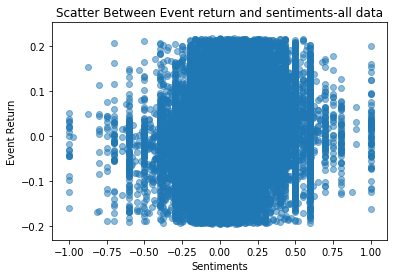

In [2262]:
plt.scatter(data_df['sentiment_textblob'],data_df['ret'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

In [2263]:
corrlation = data_df['ret'].corr(data_df['sentiment_textblob'])
print(corrlation)

0.1372422917106565


The correlation is positive, which means that news with positive sentiments lead to positive return and is expected. However,the correlation isn't very high. Even looking at the overall scatter plot, we see the majority of the sentiments concentrated around 0, and also we see a significant positive relationship between the sentiments and Event Return. Let us look at the scatterplot for one of the stock ticker(AAPL). 

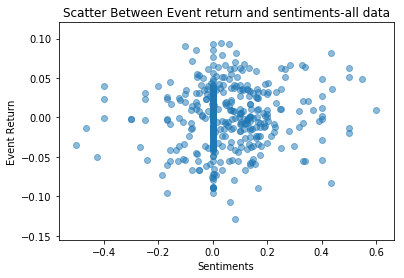

In [2264]:
data_df_stock  = data_df[data_df['ticker'] == 'AAPL']
plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['ret'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

Overall, from the results we can see that there isn't a strong correlation between the news and the sentiments. Also, there are a lot of sentiments centred around 0. We can question if the sentiment score trained on the movie reviews work on the stock price. Let us perform the assessment of the sentiment score by the textblob using the statement we discussed before.
The .sentiment_assessments attribute lists the underlying values for each token and can help us understand the reason for the overall sentiment of a sentence. 

In [933]:
text = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the company should be reversed."
TextBlob(text).sentiment_assessments

Sentiment(polarity=0.5, subjectivity=0.5, assessments=[(['touching'], 0.5, 0.5, None)])

We see that the statement has a positive sentiment of .5 but looking at the words that give rise to the sentiments, the word "touching" and not "high" causes positive sentiment. So, probably a sentiment analysis algorithm pretrained on movie/product reviews might not perform well with news sentiment analysis for stock market. Hence we might need sentiments trained on the financial news. Let us take a look at that in the next step.

<a id='4.2'></a>
## 4.2 - Supervised Learning-Classification algorithms and LSTM

In this step, we develop customised model for sentiment analysis, based on available labelled data. The label data for this is obtained from kaggle website. Let us look at the data.

In [2239]:
sentiments_data = pd.read_csv(r'Data\Project6500.csv',encoding = "ISO-8859-1")

In [2240]:
sentiments_data.head(5)

,datetime,headline,ticker,sentiment
0,1/16/2020 5:25,$MMM fell on hard times but could be set to re...,MMM,0
1,1/11/2020 6:43,Wolfe Research Upgrades 3M $MMM to ¡§Peer Perf...,MMM,1
2,1/9/2020 9:37,3M $MMM Upgraded to ¡§Peer Perform¡¨ by Wolfe ...,MMM,1
3,1/8/2020 17:01,$MMM #insideday follow up as it also opened up...,MMM,1
4,1/8/2020 7:44,$MMM is best #dividend #stock out there and do...,MMM,0


In [2238]:
print(sentiments_data.shape[0],',', sentiments_data.ticker.unique().shape[0])

9470 , 30


The data has headlines for the news across 30 different stocks, with total 9470 rows, and has sentiments lacelled 0 and 1. The headlines are already in almost cleaned. We perform the classification steps that we discussed in chapter 6, using the classification model development python template discussed in that chapter. 

In order to run a supervised learning model, we first need to convert the news headlines into feature representation. We can use different methods such as bag of words, tf-idf for feature reprentation. For this exercise, we use pretrained word embedding models from SpaCy (discussed in the theory section of this chapter). The underlying vector representations come from SpaCy is a word embedding model which generally produces a dense multi-dimensional semantic representation of words (as shown in the example below). The word embedding model includes 20k unique vectors with 300 dimensions. 

In [944]:
#word-embedding
all_vectors = pd.np.array([pd.np.array([token.vector for token in nlp(s) ]).mean(axis=0)*pd.np.ones((300)) \
                           for s in sentiments_data['headline']])

Now that we have prepared the independent variable we train the classification model in a similar manner as discussed in chapter 6. We first divide the data into training set and test set and futher run the key classification models. 

In [945]:
# split out validation dataset for the end
Y= dataset["sentiment"]
X = all_vectors

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
validation_size = 0.3
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
models.append(('RF', RandomForestClassifier()))

Running all the classification models

In [947]:
results = []
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)
   # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = accuracy_score(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = accuracy_score(res.predict(X_test), Y_test)
    test_results.append(test_result)    
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)
    print(confusion_matrix(res.predict(X_test), Y_test))
    #print(classification_report(res.predict(X_test), Y_test))

LR: 0.881882 (0.008648) 0.896666 0.874340
[[1043  166]
 [ 191 1441]]
KNN: 0.786244 (0.025196) 0.868758 0.788103
[[ 935  303]
 [ 299 1304]]
CART: 0.690602 (0.011653) 0.999698 0.689194
[[ 783  432]
 [ 451 1175]]
SVM: 0.895004 (0.010993) 0.920652 0.897923
[[1088  144]
 [ 146 1463]]
NN: 0.925781 (0.008763) 0.999698 0.931362
[[1127   88]
 [ 107 1519]]
RF: 0.810830 (0.016579) 0.999698 0.818022
[[ 861  144]
 [ 373 1463]]


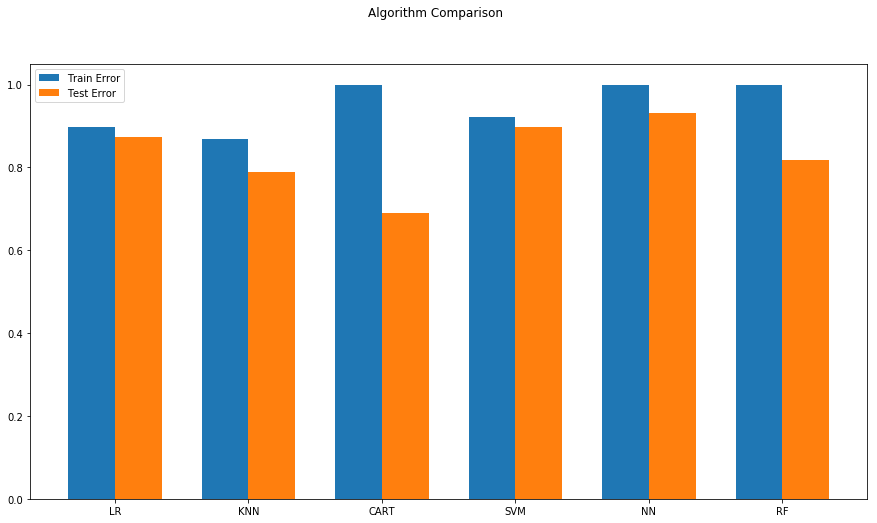

In [948]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

As we can see the NN model is the best performer with the a training accuracy of 99% and test accuracy of 93%. The performance of Random forest, SVM and Logistic regression are good as well. CART and KNN don't perform as good as other models. CART has higher overfitting as well. 

### LSTM based model

In the above code snippet, we used the some of the model function which look at the individual works in the sentence for training. However, for NLP, RNN based model are preferred over other machine learning models as RNN stores the information for current feature as well neighboring features for prediction. It maintains a memory based on history information, which enables the model to predict the current output conditioned on long distance features and looks at the words in the context of the entire sentence, rather than looking at them word. We use LSTM model in this step. 

Tokenization of sentences is one of the essential parts in natural language processing. Tokenization simply divides a sentence into a list of words. 

In order to feed this data into our RNN, all input documents must have the same length. We used Keras tokenizer function to tokenize the strings and the used another important function ‘texts_to_sequences’ to make sequences of words. More details can be found on the Kears website. We will limit the maximum review length to max_words by truncating longer reviews and padding shorter reviews with a null value (0). We can accomplish this using the pad_sequences() function in Keras.The third parameter is the input_length of 50, which is the length of each comment sequence. 

In [952]:
### Create sequence
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(sentiments_data['headline'])
sequences = tokenizer.texts_to_sequences(sentiments_data['headline'])
X_LSTM = pad_sequences(sequences, maxlen=50)

Dividing the data into the training and test set. 

In [954]:
Y_LSTM = dataset["sentiment"]
X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(X_LSTM, \
                       Y_LSTM, test_size=validation_size, random_state=seed)

In the following code snippet, we used Keras library to build a neural network classifier. The network starts with an embedding layer. The layer lets the system expand each token to a more massive vector, allowing the network to represent a word in a meaningful way. The layer takes 20000 as the first argument, which is the size of our vocabulary, and 300 as the second input parameter, which is the dimension of the embedding. Finally the function KerasClassifier given that this is a classification problem and the output needs to be labelled as 0 or 1. 

In [14]:
from keras.wrappers.scikit_learn import KerasClassifier
def create_model(input_length=50):
    model = Sequential()
    model.add(Embedding(20000, 300, input_length=50))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model    
model_LSTM = KerasClassifier(build_fn=create_model, epochs=3, verbose=1, validation_split=0.4)
model_LSTM.fit(X_train_LSTM, Y_train_LSTM)

In [15]:
train_result_LSTM = accuracy_score(model_LSTM.predict(X_train_LSTM), Y_train_LSTM)
# Test results
test_result_LSTM = accuracy_score(model_LSTM.predict(X_test_LSTM), Y_test_LSTM)

Computing the accuracy and confusion metrics. 

In [2241]:
print(train_result_LSTM,test_result_LSTM)

0.9806909036053704 0.9598732840549102


In [16]:
# confusion_matrix(model_LSTM.predict(X_test_LSTM), Y_test_LSTM)

In [962]:
train_results.append(train_result_LSTM);test_results.append(test_result_LSTM)

In [967]:
names.append("LSTM")

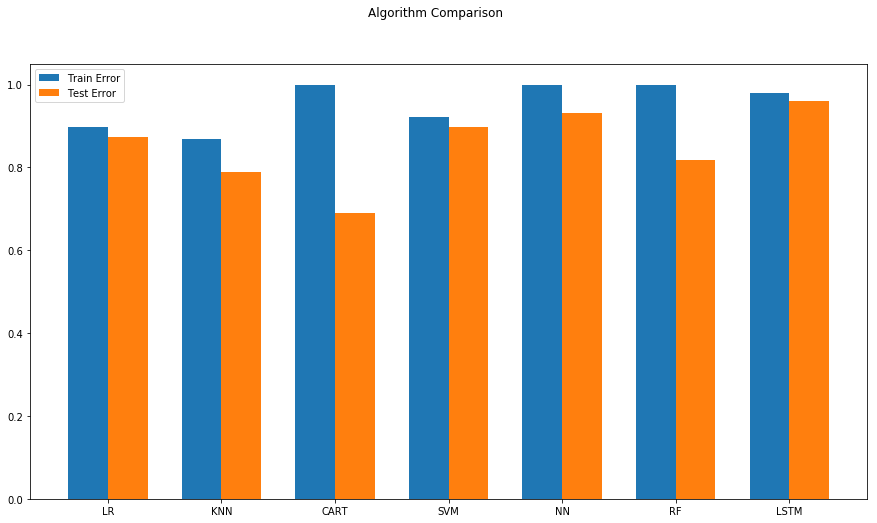

In [969]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

As expected, the LSTM model has the best performance in the test set as compared to all other models that we saw before. Let us use LSTM model for the computation of the sentiments in the data. 

In [2265]:
sequences_LSTM = tokenizer.texts_to_sequences(data_df['headline'])
X_LSTM = pad_sequences(sequences_LSTM, maxlen=50)

In [17]:
Y_LSTM = model_LSTM.predict(X_LSTM)

In [2267]:
data_df['sentiment_LSTM'] = Y_LSTM 

In [2268]:
corrlation = data_df['ret'].corr(data_df['sentiment_LSTM'])
print(corrlation)

0.16690219177163793


In [2270]:
data_df.head(1)

,ticker,date,headline,ret,ret_curr,ret_next,sentiment_textblob,sentiment_LSTM
0,CGNX,2011-05-02,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,0.167218,0.009032,0.165539,0.0,1


<a id='4.3'></a>
## 4.3 - Unsupervised - Model based on financial lexicon

Lexicons are special dictionaries or vocabularies that have been created for analyzing sentiments. Most of these lexicons have a list of positive and negative polar words with some score associated with them, and using various techniques like the position of words, surrounding words, context, parts of speech, phrases, and so on, scores are assigned to the text documents for which we want to compute the sentiment. After aggregating these scores, we get the final sentiment.

VADER (Valence Aware Dictionary for Entiment Reasoning) is a pre-built sentiment analysis model included in the NLTK package. It can give both positive/negative (polarity) as well as the strength of the emotion (intensity) of a text. It is rule-based and relies heavily on humans rating texts. These are words or any textual form of communication generally labelled according to their semantic orientation as either positive or negative) to be used us. In this case study, we update the VADER lexicon with words+sentiments from a lexicon adapted to stock market conversations in microblogging services (e.g., StockTwits, Twitter). This lexical resource was automatically created using diverse statistical measures and a large set of labeled messages from StockTwits. The source of this lexicon is *Oliveira, Nuno, Paulo Cortez, and Nelson Areal. "Stock market sentiment lexicon acquisition using microblogging data and statistical measures." Decision Support Systems 85 (2016): 62-73.*
The sentiments are between -1 and 1 similar to the sentiments from Textblob

In [3]:
# stock market lexicon
sia = SentimentIntensityAnalyzer()
stock_lex = pd.read_csv('Data/lexicon_data/stock_lex.csv')
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

final_lex = {}
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

In [2271]:
vader_sentiments = pd.np.array([sia.polarity_scores(s)['compound'] for s in data_df['headline']])
vader_sentiments.shape

(64443,)

In [14]:
text = "AAPL is trading higher after reporting its October sales rose 12.6% M/M. It has seen a 20%+ jump in orders"

In [15]:
sia.polarity_scores(text)['compound']

0.4535

In [2274]:
data_df['sentiment_lex'] = vader_sentiments

In [2275]:
corrlation = data_df['ret'].corr(data_df['sentiment_lex'])
print(corrlation)

0.21369986521030715


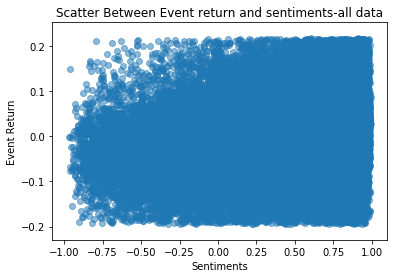

In [1069]:
plt.scatter(data_df['sentiment_lex'],data_df['ret'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

We don's see many high returns for lower sentiments, but the data may not be very clear. Let us look at the result for one of the stock tickers. 

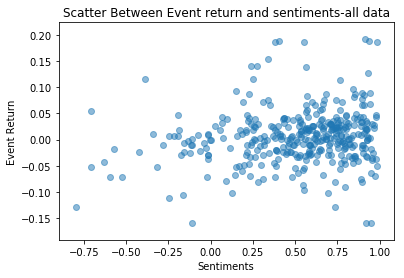

In [1134]:
data_df_stock  = data_df[data_df['ticker'] == 'AMZN']
plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['ret'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

We see a positive correlation between the Event return and sentiments. We will look deeper into the comparison of different types of the sentiment analysis in the next section.

<a id='4.4'></a>
## 4.4 Exploratory Data Analysis and comparison

Let us look at the sample headlines and the the sentiments from three different methodology, followed by the analysis using visualization. 

In [2316]:
data_new_df_stock=data_df[data_df['ticker']== 'TSM'][['ticker','headline','sentiment_textblob','sentiment_LSTM','sentiment_lex']]
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(data_new_df_stock.head(1))

,ticker,headline,sentiment_textblob,sentiment_LSTM,sentiment_lex
4620,TSM,"TSMC (TSM +1.8%) is trading higher after reporting its October sales rose 12.6% M/M. DigiTimes adds TSMC has seen a 20%+ jump in orders from QCOM, NVDA, SPRD, and Mediatek. The numbers suggest TSMC could beat its Q4 guidance (though December tends to be weak), and that chip demand could be stabilizing after getting hit hard by inventory corrections. (earlier) (UMC sales)",0.036667,1,0.5478


Looking at one of the headlines, the sentiment from this sentence is positive. However, texblob sentiment results is small suggesting that the sentiment isn't very positive, which goes back to the previous assumption that the model trained on the movie sentiment might not work accuractely for the stock sentiments. Classification based model correctly suggests the sentiment to be positive, but it is binary. Sentiment_lex has a more intuitive output with significantly positive sentiment which is in line with the financial news. Let us look at the correlation of all the sentiments from different methodology vs. return.

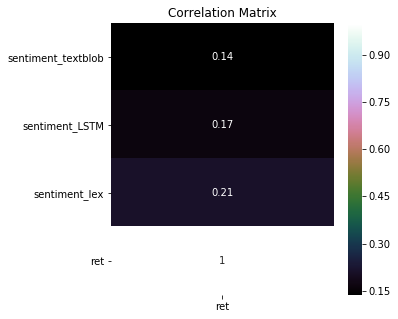

In [1977]:
correlation = data_df[['sentiment_textblob','sentiment_LSTM','sentiment_lex','ret']].dropna(axis=0).corr()
plt.figure(figsize=(5,5))
plt.title('Correlation Matrix')
sns.heatmap(correlation[['ret']], vmax=1, annot=True,cmap='cubehelix')

All the sentiments have positive relationship with the return which is intuitive and expected. The sentiments from the lexicon methodology is highest, which means the returns can be best predicted using the lexicon methodology. Also, as we saw before the lexicon based methodology is based on financial terms and is one of most accurate methodologies in predicting financial sentiments correctly. LSTM based method also performs better than textblob methodology, but the performance is slighly poor as compared to the lexicon based methodology. Let us look at the performance of the methodolgy at the ticker level. We choose the few tickers with the highest market cap for the analysis. 

In [2152]:
corr_data = []
for ticker in data_df['ticker'].unique():
    data_new_df_stock=data_df[data_df['ticker']==ticker]
    #Only look for the stocks with sufficient data
    if data_new_df_stock.shape[0] > 40 : 
        corr_textblob= data_new_df_stock['ret'].corr(data_new_df_stock['sentiment_textblob'])    
        corr_LSTM = data_new_df_stock['ret'].corr(data_new_df_stock['sentiment_LSTM'])
        corr_lex = data_new_df_stock['ret'].corr(data_new_df_stock['sentiment_lex'])
        corr_data.append([ticker,corr_textblob, corr_LSTM, corr_lex])
        #print(ticker,corr_vader, corr_LSTM, corr_textblob)
    else:
        continue

In [2153]:
corr_df = pd.DataFrame(corr_data, columns =  ['ticker','corr_textblob','corr_LSTM','corr_lex'])  
corr_df=corr_df.set_index('ticker')
corr_df.head(1)

,corr_textblob,corr_LSTM,corr_lex
ticker,,,
AMZN,0.047306,0.10235,0.166883


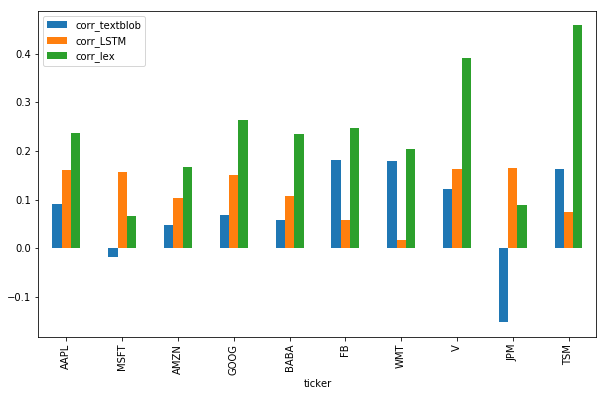

In [2154]:
#corr_df.to_csv("correlation.csv")     
tickers = ['AAPL','MSFT','AMZN','GOOG','BABA','FB','WMT','V','JPM','TSM']
corr_df.loc[tickers].plot.bar(figsize = (10,6))
plt.show()

Looking at the chart the corrlation from the lexicon methodology is highest across all the stock tickers, which corraborates the conclusion from the previous analysis. It means the returns can be best predicted using the lexicon methodology. Textblob based sentiment shows unintuitive results in some cases such as JPM. LSTM based method also performs better than textblob methodology, but the performance is slighly poor as compared to the lexicon based methodology. Let us look at the scatterplot for lexicon bs textblob methodology. We don't look at the LSTM based method as the sentiments are only labelled as 0 or 1 for this method and the scatterplot might not be very meaningful. 

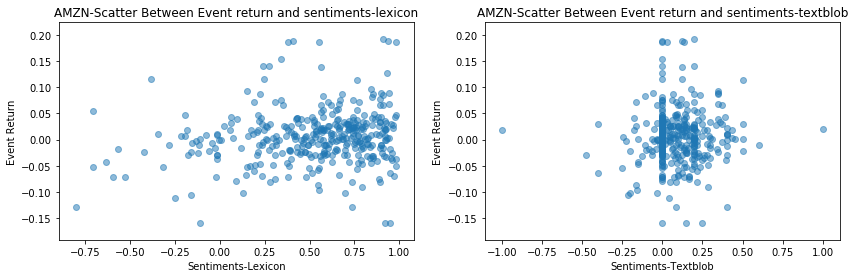

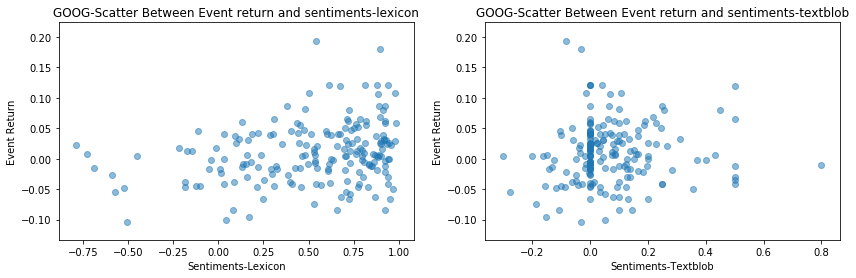

In [2317]:
#tickers = corr_df.nlargest(5,'corr_lex').index
for ticker in tickers[2:4]:
    data_df_stock  = data_df[data_df['ticker'] == ticker]
    fig = plt.figure(figsize=(14, 4), constrained_layout=False)

    plt.subplot(1, 2, 1)
    plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['ret'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-lexicon')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Lexicon')

    
    plt.subplot(1, 2, 2)
    plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['ret'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-textblob')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Textblob')
    plt.show()
    

The lexicon based sentiments on the left definitely shows a positive relationship between the sentiments and return. Some of the point with the highest returns are with the news with most positive sentiments. Also, scatterplot is more uniformly distributed in case of lexicon as compared to texblob. The sentiments for texblob are concentrated around 0, probably because the model isn't not able to categorize financial sentiments well, given it is trained on the movie reviews. Hence, for the trading strategy, we would be using the lexicon based sentiments as these are the most accurate based on the analysis in this section. The LSTM based sentiments are good as well, but as they are labelled either 0 or 1, lexicon based sentiments are preferred as these are more granular. 

<a id='5'></a>
# 5 Preparing the data with sentiment and word vector

The sentiment data can be used in different ways for the trading strategy. These can be used as additional features over and above other features(such as correlated stocks, technical indicators) in a supervised learning model to predict the price and hence come up with a trading strategy. They can also be used on a standalone signals to decide buy/sell or hold action. Additionally, the word vectors which are generated from the news can be used as additional features to predict the price and hence come up with a trading strategy. We look as first using the sentiments on a standalone basis followed by usage of word vector as feature.

<a id='5.1'></a>
## 5.1. Using Sentiments data

In this strategy we select the tickers whose return are highest correlated with the news sentiments and use the news sentiments to trade those. First choosing the 5 most correlated tickers from the list of all the tickers. 

In [2318]:
tickers = corr_df.nlargest(5,'corr_lex').index
tickers

Index(['ANF', 'HTZ', 'CHTR', 'CAR', 'AMBA'], dtype='object', name='ticker')

In [2027]:
data_new_df_stock=data_df[data_df['ticker'].isin(tickers)]

Dividing the data into training set and the test set. 

In [2028]:
train_df = data_new_df_stock.loc[data_new_df_stock['date'] < '2017-01-01', :]
test_df = data_new_df_stock.loc[data_new_df_stock['date'] >= '2017-01-01', :]
data_new_df_stock.shape

(317, 309)

Looking at the regression results between the return and sentiments for the higest correlated stocks. We can select other supervised learning algorithm for the prediction, but we stick to regression for the simplicity. 

In [2029]:
Y_col = 'ret'
X_cols = 'sentiment_lex'

In [2030]:
Y_train_sentiments = train_df.loc[:, Y_col]; Y_test_sentiments = test_df.loc[:, Y_col]
X_train_sentiments = train_df.loc[:, X_cols]; X_test_sentiments = test_df.loc[:, X_cols]
X_train_sentiments = sm.add_constant(X_train_sentiments); X_test_sentiments = sm.add_constant(X_test_sentiments)

model_sentiments = sm.OLS(Y_train_sentiments,X_train_sentiments)
results_sentiments = model_sentiments.fit()
print(results_sentiments.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     108.3
Date:                Thu, 23 Apr 2020   Prob (F-statistic):           3.47e-21
Time:                        12:05:42   Log-Likelihood:                 342.46
No. Observations:                 243   AIC:                            -680.9
Df Residuals:                     241   BIC:                            -673.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0390      0.005     -7.482

There is a strong connection between the retun and the sentiment of the headline. Also, the sentiments are significant given the p-value is close to 0. Let us look at the result on the test set.

In [2319]:
Y_hat = results_sentiments.predict(X_test_sentiments)

In [2085]:
test_df['ret_pred'] = Y_hat.values
test_df['s_ret'] = test_df.apply(lambda x: x['ret_next'] if x['ret_pred'] > 0.0 else -x['ret_next'] if x['ret_pred'] < -0.0 else 0, axis=1)
ret_s = (test_df.groupby('date')['s_ret'].mean()).cumsum()

In [2086]:
ret_spy = df.loc[df['TICKER'] == 'SPY', ['date', 'RET']].set_index('date')
ret_spy.index = [x.strftime('%Y-%m-%d') for x in ret_spy.index]
ret_spy = pd.Series(ret_spy.loc[ret_s.index.min():ret_s.index.max()]['RET']).cumsum()

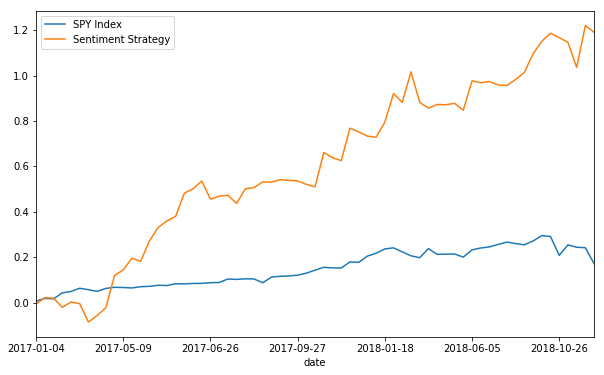

In [2087]:
data_combined = pd.DataFrame(ret_spy).join(pd.DataFrame(ret_s), how = 'right')
data_combined.rename(columns={'RET':'SPY Index','s_ret':'Sentiment Strategy',},inplace=True)
data_combined.plot(figsize=(10,6))

We see a better performance of the sentiment based strategy as compared to the index, and we can conclude that our sentiment based strategy performs quite well on the test set. The approach can be further tweaked to include more stock tickers or using another features such as correlated variables and technical indicators along with the news sentiments.   

<a id='5.2'></a>
## 5.2. Using Word vectors as features

As mentioned before, word vectors are nothing but additional features that contain the information inside the news.  We can think of these as principal components with the information from the news embedded inside them. Hence, we can expect sentiment and word vectors to have a close relationship. There are different ways of getting the word vectors or word embeddinng such as word2vec, gloVe. In this example we will use word vectors of 300 dimensions generated from the spaCy package.

In [7]:
all_vectors_wordvec = pd.np.array([pd.np.array([token.vector for token in nlp(s) ]).mean(axis=0)*pd.np.ones((300)) \
                           for s in data_df['headline']])

In [8]:
 for i in range(300):                
          data_df['av_{0}'.format(i+1)] = all_vectors_wordvec[:, i].tolist()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
data_df.head(1)

,ticker,date,headline,ret,ret_curr,ret_next,av_1,av_2,av_3,av_4,...,av_291,av_292,av_293,av_294,av_295,av_296,av_297,av_298,av_299,av_300
0,CGNX,2011-05-02,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,0.167218,0.009032,0.165539,-0.201932,0.280665,-0.014019,-0.076824,...,-0.021934,-0.036683,0.037379,-0.031393,-0.12902,0.004051,-0.209312,-0.167225,0.06115,-0.044462


There are 300 additional columns for the 300 word vectors. Let us look at correlation of the return vs these word vector. 

We check which of the features have highest correlation with the return 


In [2092]:
ColSel =  ['ret']+['av_{0}'.format(i+1) for i in range(300)]
dataforTraining=data_df.loc[:, ColSel]

In [2093]:
correlation = dataforTraining.dropna(axis=0).corr()

We choose top 150 word vector with the high number of correlation. The number of word vectors are high to incorporate more information related to news. In the next step we will be performing portfolio optimization with less number of word vector. 

In [2320]:
Y_col = ['ret']
X_cols  = correlation.nlargest(150,'ret').index.drop('ret') 

In [2321]:
train_df = data_df.loc[data_df['date'] < '2017-01-01', :]
test_df = data_df.loc[data_df['date'] >= '2017-01-01', :]

Let us look at the regression result. There can be other supervised learning models used for the prediction, but we stick to basic linear regression here. 

In [2118]:
Y_train_wordvec = train_df.loc[:, Y_col]; Y_test_wordvec = test_df.loc[:, Y_col];
X_train_wordvec = train_df.loc[:, X_cols]; X_test_wordvec = test_df.loc[:, X_cols];
X_train_wordvec = sm.add_constant(X_train_wordvec); X_test_wordvec = sm.add_constant(X_test_wordvec)

model_wordvec = sm.OLS(Y_train_wordvec,X_train_wordvec)
results_wordvec = model_wordvec.fit()
print(results_wordvec.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     42.28
Date:                Thu, 23 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:19:23   Log-Likelihood:                 57353.
No. Observations:               46455   AIC:                        -1.144e+05
Df Residuals:                   46305   BIC:                        -1.131e+05
Df Model:                         149                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0627      0.006     10.589      0.0

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


The R-2 is around 12%, which is not significant enough, but the p values of a large number of word vectors are close to 0, which means that are significant. Let us look at the result on the test set. 

In [2120]:
Y_hat = results_wordvec.predict(X_test_wordvec)

In [2121]:
test_df['ret_pred'] = Y_hat.values
test_df['s_ret'] = test_df.apply(lambda x: x['ret_next'] if x['ret_pred'] > 0.0 else -x['ret_next'] if x['ret_pred'] < -0.0 else 0, axis=1)
ret_s = (test_df.groupby('date')['s_ret'].mean()).cumsum()

In [2122]:
ret_spy = df.loc[df['TICKER'] == 'SPY', ['date', 'RET']].set_index('date')
ret_spy.index = [x.strftime('%Y-%m-%d') for x in ret_spy.index]
ret_spy = pd.Series(ret_spy.loc[ret_s.index.min():ret_s.index.max()]['RET']).cumsum()

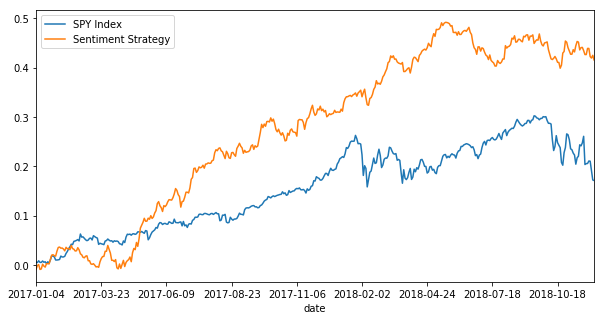

In [2123]:
data_combined = pd.DataFrame(ret_spy).join(pd.DataFrame(ret_s), how = 'right')
data_combined.rename(columns={'RET':'SPY Index','s_ret':'Sentiment Strategy',},inplace=True)
data_combined.plot(figsize=(10,5))

We see a better performance of the word vector based strategy as compared to the index, and we can conclude that our word vector based strategy performs quite well on the test set. The approach can be further tweaked to include more stock tickers or using another features such as correlated variables and technical indicators along with the news sentiments. Having discussed the approaches of trading strategy using sentiments and word vectors, let us now discuss how we can improve the performance further using portfolio optimization. 

<a id='6'></a>
# 6. Portfolio Optimization-using word vectors

In this step, we run optimization on the word vector to select the weights on each word vector by maximising the retun and the sharp ratio. We first begin with using top 10 highest correlated word vectors. 

In [ ]:
features = list(correlation.nlargest(10,'ret').index.drop('ret') )

Gerring the returns for stock tickers from the CRSP file

In [12]:
ret_mat = df.drop_duplicates(subset=['date', 'TICKER']).pivot(index='date', columns='TICKER', values='RET')
df['RET'] = pd.to_numeric(df['RET'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
df = df.loc[df['date'] > '2011-01-01'].dropna()
df['date'] = df['date'].apply(lambda x: x.date())

df = df.drop_duplicates(subset=['date', 'TICKER'])
ret_spy = df.loc[df['TICKER'] == 'SPY', ['date', 'RET']].set_index('date').loc[:, 'RET']
ret_mat = df.pivot(index='date', columns='TICKER', values='RET')

In [2332]:
ret_mat.tail(1)

TICKER,A,AA,AAAP,AAAU,AABA,AAC,AACC,AADR,AAI,AAIT,...,ZTO,ZTR,ZTS,ZU,ZUMZ,ZUO,ZX,ZYME,ZYNE,ZZ
date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,0.010862,0.026641,NaN,NaN,NaN,-0.002062,0.0371,0.007473,0.010825,NaN,...,NaN,0.0,NaN,NaN,0.010048,NaN,NaN,NaN,NaN,0.023973


Getting the stock tickers and the word vector

In [2168]:
f_df = rr_df.drop_duplicates(subset=['date', 'ticker']).loc[:, ['const'] + features]
f_df = rr_df.drop_duplicates(subset=['date', 'ticker']).loc[:, ['date', 'ticker', 'const'] + features]

In [2322]:
f_df.head(1)

,date,ticker,const,av_227,av_118,av_58,av_62,av_92,av_300,av_16,av_144,av_48
0,2011-05-02,CGNX,1,0.011242,-0.18608,0.036464,-0.13793,0.024255,-0.044462,-0.045816,0.010714,0.139689


In [2170]:
train_f = f_df[f_df['date'] < '2017-01-01']
test_f = f_df[f_df['date'] >= '2017-01-01']

<a id='6.1'></a>
## 6.1 Return maximization based portfolio weights
In this step, we perform the portfolio optimization on the word vector to further enhance the return of the portfolio and in the process the assign the weights to the word vector.   

### Word Vector Analysis 

In [2340]:
theta_0 = np.zeros((len(features)+1))
w_df = train_f.loc[:, ['date', 'ticker']]

In [2172]:
w_df['weights'] = np.NaN
w_df['date'] = w_df['date'].apply(lambda x: pd.to_datetime(x).date())

w_mat = w_df.pivot(index='date', columns='ticker', values='weights')
train_mat = ret_mat.loc[w_mat.index, w_mat.columns]

In [2175]:
def f(theta):
    #w_df['weights'] = (2/(1+np.exp(-train_f.iloc[:, 2:].dot(theta))) - 1)
    w_df['weights'] = np.minimum(np.ones((train_f.shape[0])),
                        np.maximum(-np.ones((train_f.shape[0])), 
                                   train_f.iloc[:, 2:].dot(theta)))
    
    w_mat = w_df.pivot(index='date', columns='ticker', values='weights').shift(2).ffill(limit=10)
    ret_s = (train_mat * w_mat).sum(axis=1)
    return - ret_s.mean()*252

In [2176]:
res_opt = minimize(f, theta_0)

Now we test the result of optimization on the test set.

-0.5465424118048989


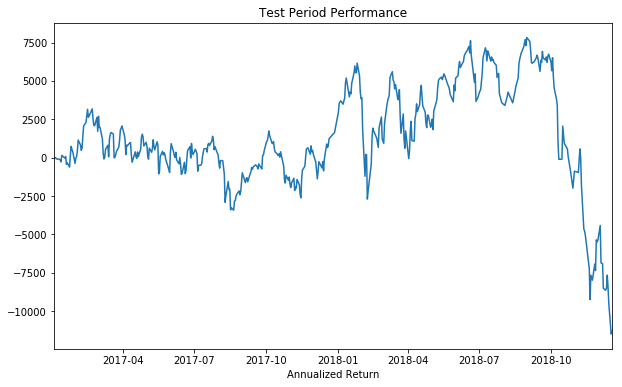

In [2177]:
theta_opt = res_opt['x']
w_df = test_f.loc[:, ['date', 'ticker']]
w_df['weights'] = np.NaN
w_df['date'] = w_df['date'].apply(lambda x: pd.to_datetime(x).date())

w_mat = w_df.pivot(index='date', columns='ticker', values='weights')

w_df['weights'] = np.minimum(np.ones((test_f.shape[0])),
                        np.maximum(-np.ones((test_f.shape[0])), 
                                   test_f.iloc[:, 2:].dot(theta_opt)))
w_mat = w_df.pivot(index='date', columns='ticker', values='weights').shift(2).ffill(limit=10)

test_mat = ret_mat.loc[w_mat.index, w_mat.columns]
ret_s = (test_mat * w_mat).sum(axis=1)
sr = ret_s.mean()/(1e-10+ret_s.std())
print(sr*np.sqrt(252))
(252*ret_s).cumsum().plot(figsize=(10,6)); plt.title('Test Period Performance'); plt.xlabel('Annualized Return');

We can see that the performance of the algorithm performance not good in the test phase. We will check the result in the training phase.

0.36110320661820544


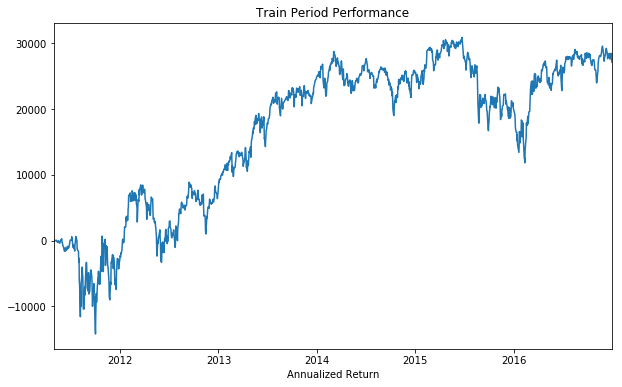

In [2178]:

w_df = train_f.loc[:, ['date', 'ticker']]
w_df['weights'] = np.NaN
w_df['date'] = w_df['date'].apply(lambda x: pd.to_datetime(x).date())

w_mat = w_df.pivot(index='date', columns='ticker', values='weights')

w_df['weights'] = np.minimum(np.ones((train_f.shape[0])),
                        np.maximum(-np.ones((train_f.shape[0])), 
                                   train_f.iloc[:, 2:].dot(theta_opt)))
w_mat = w_df.pivot(index='date', columns='ticker', values='weights').shift(2).ffill(limit=10)

train_mat = ret_mat.loc[w_mat.index, w_mat.columns]
ret_s = (train_mat * w_mat).sum(axis=1)
sr = ret_s.mean()/(1e-10+ret_s.std())
print(sr*np.sqrt(252))

(252*ret_s).cumsum().plot(figsize=(10,6)); plt.title('Train Period Performance'); plt.xlabel('Annualized Return');

We can see that the performance of the algorithm performance is great in the Training phase but not good in the test phase.In the next step we perform model tuning in an attempt to enhance the model performance. 

<a id='6.2'></a>
## 6.2. Sharp Ratio and return based portfolio weights

 We tweak the optimization to focus on optimizing both the Sharpe Ratio and the annualized return. The new cost function is based not only on return but also on sharpe ratio. The portfolio optimization steps are similar as before. 

In [2179]:
theta_0 = np.zeros((len(features)+1))

In [2180]:
w_df = train_f.loc[:, ['date', 'ticker']]
w_df['weights'] = np.NaN
w_df['date'] = w_df['date'].apply(lambda x: pd.to_datetime(x).date())

w_mat = w_df.pivot(index='date', columns='ticker', values='weights')
train_mat = ret_mat.loc[w_mat.index, w_mat.columns]

In [2181]:
def f(theta):
    #w_df['weights'] = (2/(1+np.exp(-train_f.iloc[:, 2:].dot(theta))) - 1)
    w_df['weights'] = np.minimum(np.ones((train_f.shape[0])),
                        np.maximum(-np.ones((train_f.shape[0])), 
                                   train_f.iloc[:, 2:].dot(theta)))
    
    w_mat = w_df.pivot(index='date', columns='ticker', values='weights').shift(2).ffill(limit=10)
    ret_s = (train_mat * w_mat).sum(axis=1)
    sharpe_ratio = ret_s.mean()/(1e-10+ret_s.std())
    print(ret_s.mean()*252, np.sqrt(252)*sharpe_ratio)
    return -(0.9*ret_s.mean()*252 + 0.1*np.sqrt(252)*sharpe_ratio)

In [16]:
res_opt = minimize(f, theta_0, tol=1E-3)
theta_opt = res_opt['x']

1.0273627745339524


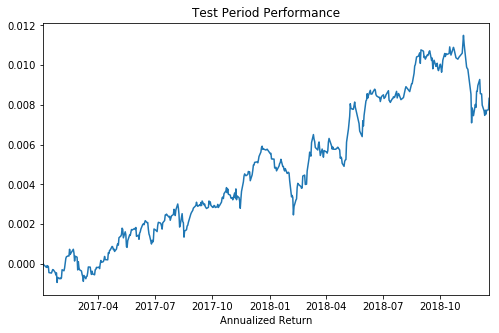

In [2193]:
w_df = test_f.loc[:, ['date', 'ticker']]
w_df['weights'] = np.NaN
w_df['date'] = w_df['date'].apply(lambda x: pd.to_datetime(x).date())

w_mat = w_df.pivot(index='date', columns='ticker', values='weights')

w_df['weights'] = np.minimum(np.ones((test_f.shape[0])),
                        np.maximum(-np.ones((test_f.shape[0])), 
                                   
                                   test_f.iloc[:, 2:].dot(theta_opt)))
w_mat = w_df.pivot(index='date', columns='ticker', values='weights').shift(2).ffill(limit=10)

test_mat = ret_mat.loc[w_mat.index, w_mat.columns]
ret_s = (test_mat * w_mat).sum(axis=1)
sr = ret_s.mean()/(1e-10+ret_s.std())
print(sr*np.sqrt(252))

(252*ret_s).cumsum().plot(figsize=(8,5)); plt.title('Test Period Performance'); plt.xlabel('Annualized Return');

Optmizing the sharp ratio, the test period return is much better that the portfolio optimized only on return.
In order to ensure that we don’t have an overly long or short position, we look at the sum of all weights across all stock each day

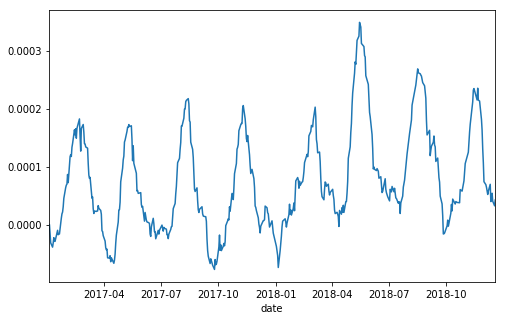

In [2195]:
w_mat.sum(axis=1).plot(figsize=(8,5));

### Train Period Performance

0.5262711105723036


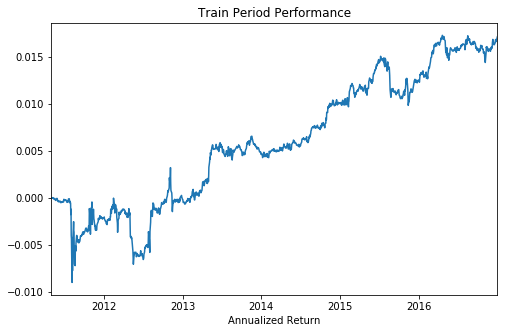

In [2197]:
w_df = train_f.loc[:, ['date', 'ticker']]
w_df['weights'] = np.NaN
w_df['date'] = w_df['date'].apply(lambda x: pd.to_datetime(x).date())

w_mat = w_df.pivot(index='date', columns='ticker', values='weights')

w_df['weights'] = np.minimum(np.ones((train_f.shape[0])),
                        np.maximum(-np.ones((train_f.shape[0])), 
                                   train_f.iloc[:, 2:].dot(theta_opt)))
w_mat = w_df.pivot(index='date', columns='ticker', values='weights').shift(2).ffill(limit=10)

train_mat = ret_mat.loc[w_mat.index, w_mat.columns]
ret_s = (train_mat * w_mat).sum(axis=1)
sr = ret_s.mean()/(1e-10+ret_s.std())
print(sr*np.sqrt(252))

(252*ret_s).cumsum().plot(figsize=(8,5)); plt.title('Train Period Performance'); plt.xlabel('Annualized Return');

 The training period performance is good. Let us check the sum of weights across the day. 

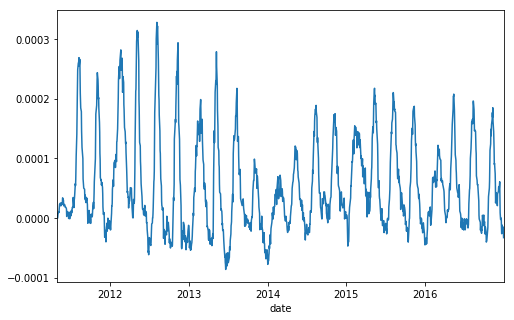

In [2198]:
w_mat.sum(axis=1).plot(figsize=(8,5));

As we can see, both during the Training and testing phase, the weights are close to zero meaning that the strategy is close to dollar neutral. Overall portfolio optimization lead to an enhance performance in the test set even with lesser number of word vectors by choosing the right metric to minimise. 

**Conclusion**

We looked at various ways in which unstructured data can be converted to structured data using the tools in natural language programming and be used for analysis and prediction. We have demonstrated three different approaches including deep learning models to develop a model for getting the sentiment analysis. We performed a comparison of the models and concluded that one of the most important step is training the model for sentiment analysis is training it using the domain-specific vocabulary. 

We also pre-trained English model by spaCy to convert a sentence into a vector of words and used these word vectors as features in the trading strategy. We further used the sentiments and the word vectors as features or signals to develop different trading strategy. This initial result suggests that the model trained on a financial lexicon based sentiments could prove a viable model for a trading strategy. 

We also saw how we can use the word vectors derived from the news data as inputs for a more complex optimization problem to generate a trading strategy.

Additional improvements to this can be made by using more complex pre-trained sentiment analysis models such as Bert by google or diffeent pre-trained NLP models available in open source platforms. Existing NLP libraries fill in some of the pre-processing and encoding steps to allow us to focus on the inference step.

Overall, this case study is a confluence of the concepts we covered earlier in this book along with the concepts of NLP discussed earlier in this book. We could definitely build on the strategy by including more correlated variables, technical indicators or even improve the sentiment analysis by using more sophisticated models on more relevant Financial News.


